# ● Libraries

In [1]:
import tqdm
import time
import numpy as np
import cv2
from sklearn.metrics import (roc_curve, auc, accuracy_score, f1_score, precision_score, 
                             recall_score, classification_report, confusion_matrix)
import seaborn as sn
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, StratifiedKFold
from dataio import *
from preprocess import *
from segment import *
from colorfeatures import *
from classify import *
from feature_extraction import *

In [84]:
# Load Prior Session Variables
import dill
#dill.dump_session('predict_env.db')
#dill.load_session('predict_env.db')

# ● Dataset

In [3]:
train_data = sortData('../data/train')                 # Load Training Set

Number of LES Images: 2400
Number of NV Images: 2400


In [4]:
val_data   = sortData('../data/val')                   # Load Validation Set

Number of LES Images: 600
Number of NV Images: 600


In [5]:
test_data   = sortData('../data/test', mode='test')     # Load Testing Set

Number of Test Images: 1015


# ● Feature Extraction: (Train+Val) Datasets

In [6]:
train_features_les = [] 
train_features_nv  = []

counter      = 0
start        = 0
stop         = len(train_data)

for index in tqdm.tqdm(range(start,stop)):
    time.sleep(0.01)

    # Load Dataset
    image    = plt.imread(train_data[index]['image'])
    scan_id  = train_data[index]['id']
    label    = train_data[index]['label']
        
    # External Preprocessing (Discontinued)
    # hr,_     = occlusion_removal(image)       # Occlusion Removal
    # cl       = clahe_LAB(hr)                  # CLAHE Preprocessing
    
    # Segmentation (Discontinued)
    # mask     = segment_lesion(image, mode="active_contours")
    # mask     = (plt.imread(train_data[index]['mask'])).astype(bool)
        
    # Feature Extraction
    features = extract_features(image)
    features = np.expand_dims(np.asarray(features),axis=0)
    
    # Pass to Feature Vectors
    if (label==1):                           # LES Features
        if (len(train_features_les)==0):
            train_features_les = features
        else:
            train_features_les = np.concatenate((train_features_les,features),axis=0)
    if (label==0):                           # NV Features
        if (len(train_features_nv)==0):
            train_features_nv = features
        else:
            train_features_nv = np.concatenate((train_features_nv,features),axis=0)
    counter = counter + 1

print("Features Extraction (Training Set) Complete: "+str(counter))

100%|████████████████████████████████████████████████████████████████████████████| 4800/4800 [2:44:30<00:00,  2.06s/it]


Features Extraction (Training Set) Complete: 4800


In [7]:
val_features_les = [] 
val_features_nv  = []

counter      = 0
start        = 0
stop         = len(val_data)

for index in tqdm.tqdm(range(start,stop)):
    time.sleep(0.01)

    # Load Dataset
    image    = plt.imread(val_data[index]['image'])
    scan_id  = val_data[index]['id']
    label    = val_data[index]['label']
    
    # External Preprocessing (Discontinued)
    # hr,_     = occlusion_removal(image)       # Occlusion Removal
    # cl       = clahe_LAB(hr)                  # CLAHE Preprocessing
    
    # Segmentation (Discontinued)
    # mask     = segment_lesion(cl, mode="active_contours")   
    # mask     = (plt.imread(train_data[index]['mask'])).astype(bool)
    
    # Feature Extraction
    features = extract_features(image)
    features = np.expand_dims(np.asarray(features),axis=0)
    
    # Pass to Feature Vectors
    if (label==1):                           # LES Features
        if (len(val_features_les)==0):
            val_features_les = features
        else:
            val_features_les = np.concatenate((val_features_les,features),axis=0)
    if (label==0):                           # NV Features
        if (len(val_features_nv)==0):
            val_features_nv = features
        else:
            val_features_nv = np.concatenate((val_features_nv,features),axis=0)
    counter = counter + 1

print("Features Extraction (Validation Set) Complete: "+str(counter))

100%|██████████████████████████████████████████████████████████████████████████████| 1200/1200 [37:37<00:00,  1.88s/it]


Features Extraction (Validation Set) Complete: 1200


# ● Feature Extraction: Test Dataset

In [4]:
test_features = [] 

counter      = 0
start        = 0
stop         = len(test_data)

for index in tqdm.tqdm(range(start,stop)):
    time.sleep(0.01)

    # Load Dataset
    image    = plt.imread(test_data[index]['image'])
    scan_id  = test_data[index]['id']
    
    # External Preprocessing (Discontinued)
    # hr,_     = occlusion_removal(image)       # Occlusion Removal
    # cl       = clahe_LAB(hr)                  # CLAHE Preprocessing
    
    # Segmentation (Discontinued)
    # mask     = segment_lesion(cl, mode="active_contours")   
    # mask     = (plt.imread(train_data[index]['mask'])).astype(bool)
    
    # Feature Extraction
    features = extract_features(image)
    features = np.expand_dims(np.asarray(features),axis=0)
    
    # Pass to Feature Vectors
    if (len(test_features)==0):
        test_features = features
        test_ids      = scan_id.replace("../data/test\\", "")
    else:
        test_features = np.concatenate((test_features,features),axis=0)
        test_ids      = np.append(test_ids,scan_id)
    
    counter = counter + 1

print("Features Extraction (Testing Set) Complete: "+str(counter))

100%|██████████████████████████████████████████████████████████████████████████████| 1015/1015 [33:18<00:00,  1.97s/it]


Features Extraction (Testing Set) Complete: 1015


# ● Merge, Shuffle, Concatenate, Normalize

In [4]:
# Combine Train/Val Feature Vectors
full_features_les = np.zeros(shape=(train_features_les.shape[0]+val_features_les.shape[0],train_features_les.shape[1]))
full_features_nv  = np.zeros(shape=(train_features_nv.shape[0]+val_features_nv.shape[0],train_features_nv.shape[1]))

full_features_les[:train_features_les.shape[0],:] = train_features_les
full_features_les[train_features_les.shape[0]:,:] = val_features_les
full_features_nv[:train_features_nv.shape[0],:]   = train_features_nv
full_features_nv[train_features_nv.shape[0]:,:]   = val_features_nv

# Intra-Class Shuffle
rnd                = np.random.RandomState(8)
shuffled_indices   = rnd.permutation(np.arange(full_features_nv.shape[0]))
full_features_les  = full_features_les[shuffled_indices]
full_features_nv   = full_features_nv[shuffled_indices]

In [74]:
# Inter-Class Shuffle (Not Mandatory), Concatenation, Normalization
# "Unlike the backpropagation learning algorithm for artificial neural networks, a given SVM will always deterministically
#  converge to the same solution for a given data set, regardless of the initial conditions. [Campbell and Cristianini, 1999]"

X, Y               = concat_and_shuffled(class0=full_features_nv, class1=full_features_les, shuffled=False)

# Scaling Test Features Blindly by Those Determined During Training/Validation 
Z                  = (test_features-np.mean(X,axis=0))/np.std(X,axis=0)
X                  = (X-np.mean(X,axis=0))/np.std(X,axis=0)

# ● Classifier: Training

In [75]:
SVMclassifier = svm.SVC(C=10, kernel='rbf', gamma='scale', probability=True, class_weight='balanced', random_state=8)
SVMclassifier.fit(X,Y)

SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=8, shrinking=True, tol=0.001,
    verbose=False)

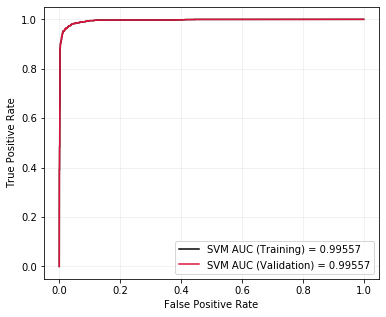

In [76]:
# Redundancy Check (Training=Validation=High)
ROC(X,Y,X,Y,SVMclassifier)

# ● Classifier: Inference

In [77]:
# Redundancy Check (Verify Order of Predictions)
expecting_label_0 = SVMclassifier.predict(X[:3000,:])
expecting_label_1 = SVMclassifier.predict(X[3000:,:])

# First 3000 samples are Class 0: NV; Second 3000 samples are Class 1: LES
# Inference Accuracy should be High, since we're predicting on the Training Set
print("Expecting 0: " + str(expecting_label_0.mean()))
print("Expecting 1: " + str(expecting_label_1.mean()))

Expecting 0: 0.03166666666666667
Expecting 1: 0.9733333333333334


In [100]:
inference_labels = SVMclassifier.predict(Z)
inference_probs  = SVMclassifier.predict_proba(Z)
inference_probs  = np.maximum(inference_probs[:,0],inference_probs[:,1])
inference_ids    = test_ids

# Predicting More NV or LES?
inference_labels.mean()

0.35763546798029555

In [101]:
predictions    =  pd.DataFrame(list(zip(inference_ids,inference_labels,inference_probs)),
columns        =  ['img_id', 'lbl', 'prob'])
predictions.to_csv('predictions_testset.csv', encoding='utf-8', index=False)  